## EY Data Challenge - Sentinel-2 Sample Notebook

This sample notebook can be used to create a Sentinel-2 satellite output product for a single date or a median mosaic for any time period. A median mosaic reflects the "median" value of pixels for all spectral bands in the time series. When scenes within a time series contain clouds, the use of a median calculation can statistically remove clouds from the final median mosaic product, assuming there are plenty of clear pixels within the time series. The output from this notebook is a GeoTIFF product suitable for further analysis and can also be used to generate spectral index products using mathematical combinations of bands, such as NDVI. The baseline data is [Sentinel-2 Level-2A](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a) data from the MS Planetary Computer catalog.

In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import rasterio
import numpy as np
import xarray as xr
import rioxarray as rio
import matplotlib.pyplot as plt
from matplotlib.cm import RdYlGn, jet, RdBu

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer 
from odc.stac import stac_load

### Discover and load the data for analysis

First, we define our area of interest using latitude and longitude coordinates. 

In [2]:
# Define the bounding box for the entire data region using (Latitude, Longitude)
# This is the region of New York City that contains our temperature dataset
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)

In [3]:
# Calculate the bounds for doing an archive data search
# bounds = (min_lon, min_lat, max_lon, max_lat)
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0]) # (min_lon, min_lat, max_lon, max_lat)

In [4]:
# Define the time window
time_window = "2021-06-01/2021-09-01"

Using the `pystac_client` we can search the Planetary Computer's STAC endpoint for items matching our query parameters. We will use a period of 3 months as a representative dataset for the region. The query searches for "low cloud" scenes with overall cloud cover <30%. The result is the number of scenes matching our search criteria that touch our area of interest. Some of these may be partial scenes or contain clouds.

In [5]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bounds, 
    datetime=time_window,
    collections=["sentinel-2-l2a"],
    query={"eo:cloud_cover": {"lt": 10}},
)
items = list(search.get_all_items())
print('This is the number of scenes that touch our region:', len(items))

This is the number of scenes that touch our region: 5


Next, we'll load the data into an [xarray](https://xarray.pydata.org/en/stable/) DataArray using [stackstac](https://stackstac.readthedocs.io/). We will only keep the commonly used spectral bands (Red, Green, Blue, NIR, SWIR). There are also several other <b>important settings for the data</b>: We have changed the projection to epsg=4326 which is standard latitude-longitude in degrees. We have specified the spatial resolution of each pixel to be 10-meters. 

In [6]:
signed_items = [planetary_computer.sign(item).to_dict() for item in items]

In [7]:
# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
resolution = 10  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for crs=4326 

### Sentinel-2 Bands Summary 
The following list of common bands can be loaded by the Open Data Cube (ODC) stac command.<br><br>
B01 = Coastal Aerosol = 60m <br>
B02 = Blue = 10m <br>
B03 = Green = 10m <br>
B04 = Red = 10m <br>
B05 = Red Edge (704 nm) = 20m <br>
B06 = Red Edge (740 nm) = 20m <br>
B07 = Red Edge (780 nm) = 20m <br>
B08 = NIR (833 nm) = 10m <br>
B8A = NIR (narrow 864 nm) = 20m <br>
B11 = SWIR (1.6 um) = 20m <br>
B12 = SWIR (2.2 um) = 20m

In [8]:
data = stac_load(
    items,
    bands=["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12", "SCL"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

In [9]:
# View the dimensions of our XARRAY and the loaded variables
# This insures we have the right coordinates and spectral bands in our xarray
display(data)

<xarray.Dataset> Size: 290MB
Dimensions:      (latitude: 1448, longitude: 1671, time: 5)
Coordinates:
  * latitude     (latitude) float64 12kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 13kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 40B 2021-06-06T15:38:09.024000 ... 202...
Data variables:
    B01          (time, latitude, longitude) uint16 24MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B02          (time, latitude, longitude) uint16 24MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B03          (time, latitude, longitude) uint16 24MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B04          (time, latitude, longitude) uint16 24MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B05          (time, latitude, longitude) uint16 24MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B06          (time, latitude, longitude) uint16 24MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B07          (time, latitude, longitude) uint16 24MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B08          (time, latitude, longitude) uint16 24MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B8A          (time, latitude, longitude) uint16 24MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B11          (time, latitude, longitude) uint16 24MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B12          (time, latitude, longitude) uint16 24MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    SCL          (time, latitude, longitude) uint16 24MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>

In [10]:
# INSERT CLOUD FILTERING STUFF HERE

# PART A: Cloud cleaning for Sentinel-2 (using SCL band)
# Filter data using the Sentinel-2 SCL band classification

# scl=0 > No Data
# scl=1 > Saturated
# scl=3 > Cloud Shadows
# scl=6 > Water 
# scl=8 > Cloud Medium Probability 
# scl=9 > Cloud High Probability
# scl=10 > Thin Cirrus Cloud

# Create a colormap to display the SCL pixel classifications

scl_colormap = np.array(
    [
        [252,  40, 228, 255],  # 0  - NODATA - MAGENTA
        [255,   0,   4, 255],  # 1  - Saturated or Defective - RED
        [0  ,   0,   0, 255],  # 2  - Dark Areas - BLACK
        [97 ,  97,  97, 255],  # 3  - Cloud Shadow - DARK GREY
        [3  , 139,  80, 255],  # 4  - Vegetation - GREEN
        [192, 132,  12, 255],  # 5  - Bare Ground - BROWN
        [21 , 103, 141, 255],  # 6  - Water - BLUE
        [117,   0,  27, 255],  # 7  - Unclassified - MAROON
        [208, 208, 208, 255],  # 8  - Cloud - LIGHT GREY
        [244, 244, 244, 255],  # 9  - Definitely Cloud - WHITE
        [195, 231, 240, 255],  # 10 - Thin Cloud - LIGHT BLUE
        [222, 157, 204, 255],  # 11 - Snow or Ice - PINK
    ],
    dtype="uint8",
)

# Create a mask for no data, saturated data, clouds, cloud shadows, and water
cloud_mask = \
    (data.SCL != 0) & \
    (data.SCL != 1) & \
    (data.SCL != 3) & \
    (data.SCL != 8) & \
    (data.SCL != 9) & \
    (data.SCL != 10) 

cleaned_data_sentinel = data.where(cloud_mask).astype("uint16")

### View RGB (real color) images from the time series
You will notice that some of the scenes have clouds. You may want to use a scene from a single date, or create a median mosaic using all of the data in the time series. Also, these images are merely for quick review and are not scaled correctly to reflect the proper Lat-Lon ratios. Finally, the numbering for these scenes starts at ZERO and goes from the top-left across the rows to reach the total number of scenes in the data array shown above. 

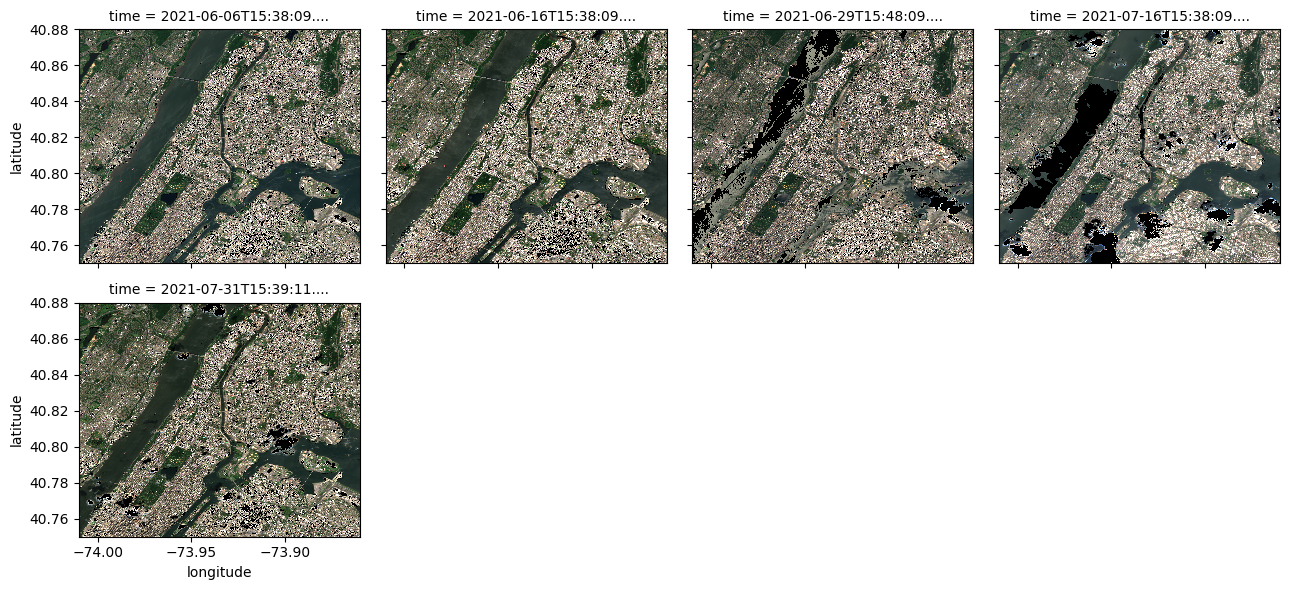

In [11]:
# Plot sample images from the time series
plot_data = cleaned_data_sentinel[["B04","B03","B02"]].to_array()
plot_data.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=2500)
plt.show()

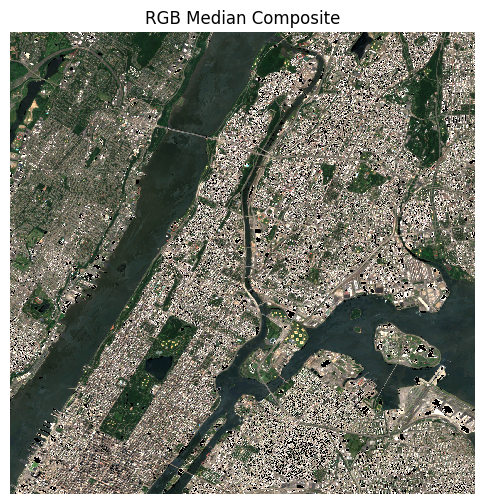

In [12]:
# Compute median over multiple dates
# Choose dates with minimal cloud covers
median = cleaned_data_sentinel.median(dim="time").compute()

# Plot an RGB image for the median composite or mosaic
# Notice how this new image is void of clouds due to statistical filtering
fig, ax = plt.subplots(figsize=(6,6))
median[["B04", "B03", "B02"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0, vmax=2500)
ax.set_title("RGB Median Composite")
ax.axis('off')
plt.show()

In [13]:
filename = "../data/S2_median_2025-03-15_v1.tiff"

In [14]:
height = median.dims["latitude"]
width = median.dims["longitude"]

# Define the Coordinate Reference System (CRS) to be common Lat-Lon coordinates
# Define the tranformation using our bounding box so the Lat-Lon information is written to the GeoTIFF
gt = rasterio.transform.from_bounds(lower_left[1], lower_left[0], upper_right[1], upper_right[0], width, height)
median.rio.write_crs("epsg:4326", inplace=True)
median.rio.write_transform(transform=gt, inplace=True);

# Create the GeoTIFF output file using the defined parameters 
with rasterio.open(filename,'w', driver='GTiff', width=width, height=height,
                   crs='epsg:4326', transform=gt, count=11, compress='lzw', dtype='float64') as dst:
    dst.write(median.B01, 1)
    dst.write(median.B04, 2)
    dst.write(median.B06, 3) 
    dst.write(median.B08, 4)
    dst.write(median.B03, 5)
    dst.write(median.B11, 6)
    dst.write(median.B02, 7)
    dst.write(median.B05, 8)
    dst.write(median.B07, 9)
    dst.write(median.B8A, 10)
    dst.write(median.B12, 11)
    dst.close()